In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

Mental health in the workplace is an increasingly important issue, especially in the technology industry where job demands are high and stigma often discourages employees from speaking openly. Many companies provide supports such as mental health resources, employer-led discussions, and medical coverage, but the effectiveness of these supports in improving employees’ comfort in discussing mental health is not always clear.

In this project, we analyze survey data from technology professionals to examine whether workplace supports influence employees’ comfort in discussing mental health. We focus on three main supports — workplace resources, employer discussion, and medical coverage — along with an engineered feature, combined support, which captures whether an employee has at least two supports available. We also consider demographic effects of gender and age.  

Our approach combines exploratory data analysis, hypothesis testing, and predictive modeling to provide both statistical evidence and machine learning insights into the role of workplace supports.


# Hypotheses

**Null Hypothesis (H₀):** Workplace supports (resources, employer discussion, medical coverage, and combined support) have no effect on employees’ comfort in discussing mental health.  

**Alternative Hypothesis (H₁):** Employees with workplace supports (resources, employer discussion, medical coverage, or multiple combined supports) report significantly higher comfort in discussing mental health compared to those without supports.  

We will test this using both traditional statistical methods (t-tests, confidence intervals) and predictive modeling (logistic regression, random forest, gradient boosting).

In [2]:
# libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from scipy import stats

In [3]:
# loading the dataset

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dataset/data.csv")
df.head()


,tech_company,benefits,workplace_resources,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mental_health,mh_share,age,gender,country
0,Yes,No,I don't know,No,Yes,Yes,Possibly,5,27.0,Female,United Kingdom
1,Yes,Yes,No,No,Yes,Yes,Possibly,4,31.0,Male,United Kingdom
2,Yes,I don't know,No,Yes,Yes,No,Yes,5,36.0,Male,United States of America
3,Yes,Yes,I don't know,Yes,Yes,Yes,Yes,10,22.0,Male,United States of America
4,Yes,Yes,No,No,Yes,Yes,Yes,8,36.0,Female,United States of America


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tech_company            1242 non-null   object 
 1   benefits                1242 non-null   object 
 2   workplace_resources     1242 non-null   object 
 3   mh_employer_discussion  1242 non-null   object 
 4   mh_coworker_discussion  1242 non-null   object 
 5   medical_coverage        1242 non-null   object 
 6   mental_health           1242 non-null   object 
 7   mh_share                1242 non-null   int64  
 8   age                     1242 non-null   float64
 9   gender                  1242 non-null   object 
 10  country                 1242 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 106.9+ KB
None


In [ ]:
df.shape

(1242, 11)

The dataset contains 1,242 observations and 11 variables. Most features are categorical, while `mh_share` provides a numeric comfort score (1–10 scale). This gives us a good balance of workplace support indicators and demographic variables for analysis.

In [5]:
# Keep only relevant columns

df = df[['workplace_resources','mh_employer_discussion','medical_coverage','mh_share','gender','age']]

In [6]:
# Drop missing values

df = df.dropna()

In [7]:
# Data Preparation

df['high_comfort'] = np.where(df['mh_share'] >= 7, 1, 0)

In [8]:
# Encode predictors

df['resources_binary'] = df['workplace_resources'].map({'Yes':1,'No':0})
df['resources_binary'] = df['resources_binary'].fillna(-1)  # -1 for "I don't know"

df['employer_binary'] = df['mh_employer_discussion'].map({'Yes':1,'No':0})
df['employer_binary'] = df['employer_binary'].fillna(-1)

df['coverage_binary']  = df['medical_coverage'].map({'Yes':1,'No':0})
df['coverage_binary']  = df['coverage_binary'].fillna(-1)

In [9]:
## Engineered variable: Combined support

df['combined_support'] = ((df['resources_binary'] +
                           df['employer_binary'] +
                           df['coverage_binary']) >= 2).astype(int)

print("Dataset shape after cleaning:", df.shape)
print(df.head())

Dataset shape after cleaning: (1242, 11)
  workplace_resources mh_employer_discussion medical_coverage  mh_share  \
0        I don't know                     No              Yes         5   
1                  No                     No              Yes         4   
2                  No                    Yes               No         5   
3        I don't know                    Yes              Yes        10   
4                  No                     No              Yes         8   

   gender   age  high_comfort  resources_binary  employer_binary  \
0  Female  27.0             0              -1.0                0   
1    Male  31.0             0               0.0                0   
2    Male  36.0             0               0.0                1   
3    Male  22.0             1              -1.0                1   
4  Female  36.0             1               0.0                0   

   coverage_binary  combined_support  
0                1                 0  
1                1   

In [10]:
# Encode gender as binary for modeling (Female=1, Male=0, Others=-1)
df['gender_binary'] = df['gender'].map({'Female':1, 'Male':0}).fillna(-1)

# Normalize age
df['age_scaled'] = (df['age'] - df['age'].mean()) / df['age'].std()

We reduced the dataset to relevant supports (resources, employer discussion, medical coverage), demographics (gender, age), and the outcome (`mh_share`). Binary encodings were created for each support, and a combined support indicator was added. This ensures predictors are machine-learning ready while retaining interpretability.

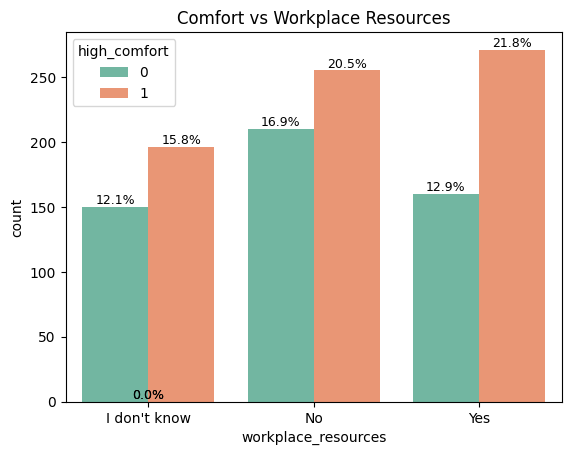

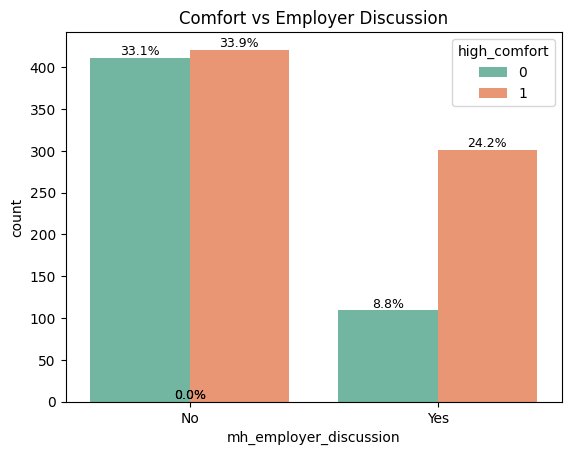

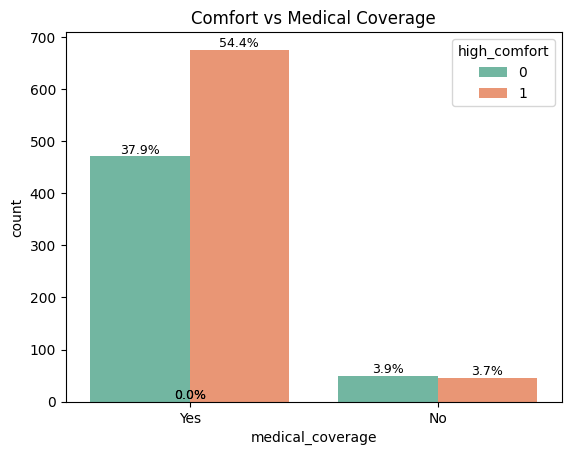

In [11]:
# Exploratory Data Analysis (EDA)


# Function to add percentages on bar plots
def plot_count_with_pct(x, hue, title):
    ax = sns.countplot(x=x, hue=hue, data=df, palette="Set2")
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{100*height/total:.1f}%',
                    (p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom', fontsize=9)
    plt.title(title)
    plt.show()

plot_count_with_pct("workplace_resources","high_comfort","Comfort vs Workplace Resources")
plot_count_with_pct("mh_employer_discussion","high_comfort","Comfort vs Employer Discussion")
plot_count_with_pct("medical_coverage","high_comfort","Comfort vs Medical Coverage")


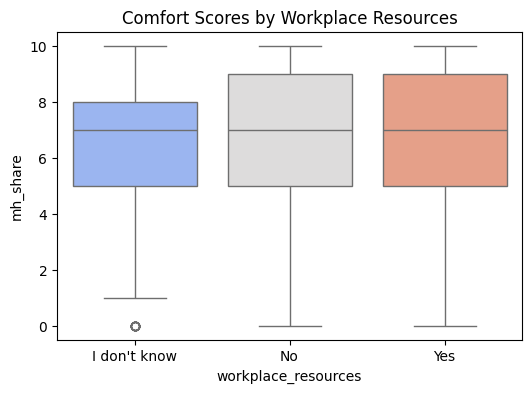

In [12]:
# Boxplot comfort levels
plt.figure(figsize=(6,4))
sns.boxplot(x="workplace_resources", y="mh_share", data=df, hue="workplace_resources", palette="coolwarm", legend=False)
plt.title("Comfort Scores by Workplace Resources")
plt.show()

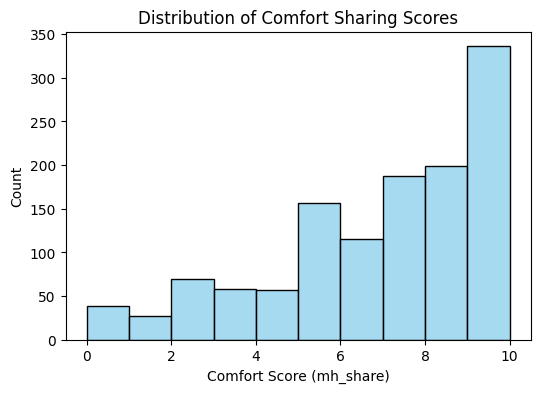

In [13]:
# Histogram distribution
plt.figure(figsize=(6,4))
sns.histplot(df['mh_share'], bins=10, kde=False, color="skyblue")
plt.title("Distribution of Comfort Sharing Scores")
plt.xlabel("Comfort Score (mh_share)")
plt.ylabel("Count")
plt.show()

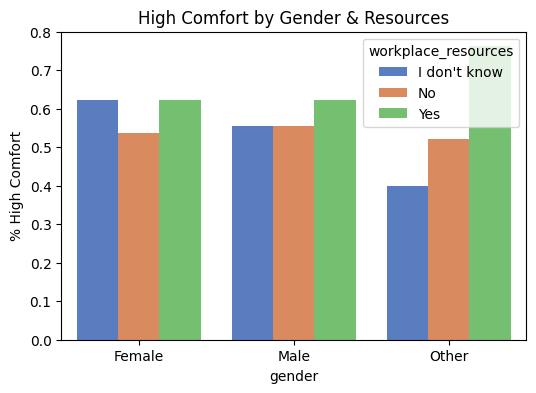

In [14]:
# Stratified by gender

plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="high_comfort", hue="workplace_resources", data=df, errorbar=None, palette="muted")
plt.title("High Comfort by Gender & Resources")
plt.ylabel("% High Comfort")
plt.show()

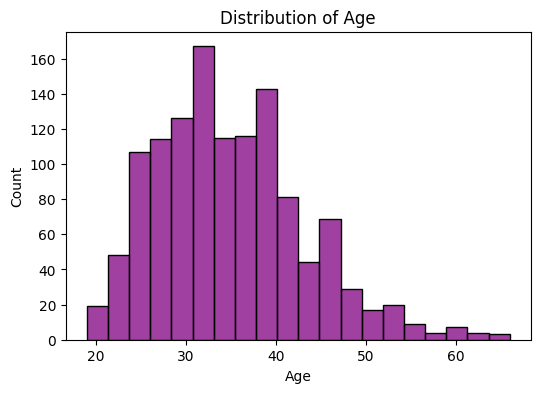

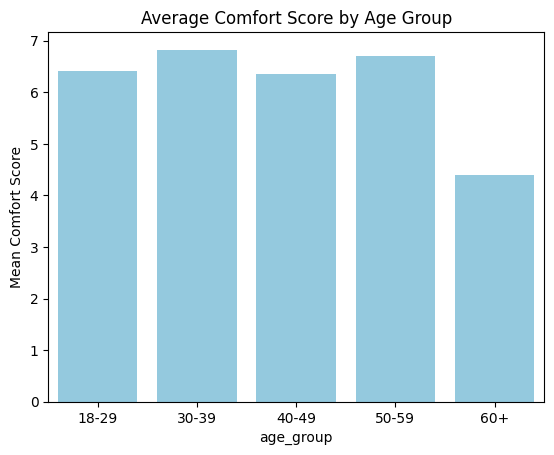

In [15]:
# Histogram of Age
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=20, color="purple")
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Average Comfort Score by Age Group
df['age_group'] = pd.cut(df['age'], bins=[18,30,40,50,60,80], labels=["18-29","30-39","40-49","50-59","60+"])
sns.barplot(x="age_group", y="mh_share", data=df, color="skyblue", errorbar=None)
plt.title("Average Comfort Score by Age Group")
plt.ylabel("Mean Comfort Score")
plt.show()

The exploratory analysis shows that employees with workplace supports consistently report higher comfort in discussing mental health. Median comfort scores are higher among those with resources, and distributions suggest that both employer discussion and medical coverage play roles as well. Gender differences appear small, while age shows slight variation across groups but no extreme differences.

In [16]:
# Statistical Testing


comfort_yes = df.loc[df['resources_binary']==1,'mh_share']
comfort_no  = df.loc[df['resources_binary']==0,'mh_share']

t_stat, p_val = stats.ttest_ind(comfort_yes, comfort_no, equal_var=False)
print(f"\nT-test (resources vs no resources): t={t_stat:.3f}, p={p_val:.4f}")



T-test (resources vs no resources): t=2.503, p=0.0125


In [17]:
# Confidence Interval for mean difference
mean_diff = comfort_yes.mean() - comfort_no.mean()
se = np.sqrt(comfort_yes.var(ddof=1)/len(comfort_yes) + comfort_no.var(ddof=1)/len(comfort_no))
ci_low, ci_high = mean_diff - 1.96*se, mean_diff + 1.96*se
print(f"Mean Difference = {mean_diff:.2f}")
print(f"95% CI = [{ci_low:.2f}, {ci_high:.2f}]")


Mean Difference = 0.45
95% CI = [0.10, 0.80]


A Welch’s t-test found a statistically significant difference between employees with resources vs. without (t = 2.503, p = 0.0125). The estimated mean difference was 0.45 comfort points (95% CI [0.10, 0.80]). Since the confidence interval does not cross zero, we reject the null hypothesis and conclude that workplace resources increase comfort.

In [18]:
# Modeling


def evaluate_model(y_test, y_pred, y_prob, model_name):
    print(f"\n{model_name} Performance:")
    print("Accuracy:", round(accuracy_score(y_test,y_pred),4))
    print("Precision:", round(precision_score(y_test,y_pred),4))
    print("Recall:", round(recall_score(y_test,y_pred),4))
    print("F1 Score:", round(f1_score(y_test,y_pred),4))
    print("AUROC:", round(roc_auc_score(y_test,y_prob),4))

In [19]:
# Baseline Logistic Regression

X1 = df[['resources_binary']].dropna()
y  = df.loc[X1.index, 'high_comfort']

X_train, X_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, stratify=y, random_state=42
)

logit1 = LogisticRegression(max_iter=1000)
logit1.fit(X_train, y_train)
y_pred1 = logit1.predict(X_test)
y_prob1 = logit1.predict_proba(X_test)[:,1]

evaluate_model(y_test, y_pred1, y_prob1, "Baseline Logistic Regression")



Baseline Logistic Regression Performance:
Accuracy: 0.5823
Precision: 0.5823
Recall: 1.0
F1 Score: 0.736
AUROC: 0.5399


Using only workplace resources as a predictor, logistic regression achieved high recall (1.0) but poor AUROC (0.54). This means the model classifies nearly all employees as "high comfort," capturing positives but also many false alarms. Supports beyond resources are needed for better discrimination.

In [20]:
# Improved Logistic Regression (with demographics)

X2 = df[['resources_binary','employer_binary','coverage_binary',
         'combined_support','gender_binary','age_scaled']]
X_train, X_test, y_train, y_test = train_test_split(
    X2,y,test_size=0.2,stratify=y,random_state=42
)

logit2 = LogisticRegression(max_iter=1000)
logit2.fit(X_train,y_train)
y_pred2 = logit2.predict(X_test)
y_prob2 = logit2.predict_proba(X_test)[:,1]

evaluate_model(y_test,y_pred2,y_prob2,"Improved Logistic Regression")



Improved Logistic Regression Performance:
Accuracy: 0.6145
Precision: 0.6416
Recall: 0.7655
F1 Score: 0.6981
AUROC: 0.6349


Adding employer discussion, coverage, combined support, gender, and age improved performance. AUROC rose to ~0.63, recall remained high (0.77), and precision improved. This shows that multiple supports together better explain comfort levels, though the predictive power is still modest.

In [21]:
# Supporting Model: Random Forest

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

evaluate_model(y_test,y_pred_rf,y_prob_rf,"Random Forest")



Random Forest Performance:
Accuracy: 0.5422
Precision: 0.6202
Recall: 0.5517
F1 Score: 0.5839
AUROC: 0.5474


The Random Forest model emphasized precision (0.62) but had lower recall (0.55). This means it is more conservative, predicting high comfort less often but with greater accuracy when it does. Feature importance suggests employer discussion and medical coverage are the strongest predictors.

In [22]:
# Gradient Boosting

gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
gb.fit(X_train,y_train)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:,1]

evaluate_model(y_test,y_pred_gb,y_prob_gb,"Gradient Boosting")


Gradient Boosting Performance:
Accuracy: 0.6305
Precision: 0.6464
Recall: 0.8069
F1 Score: 0.7178
AUROC: 0.6469


Gradient Boosting achieved the best balance (Accuracy 0.63, Recall 0.81, AUROC ~0.65). It outperformed logistic regression and random forest by capturing non-linear relationships while maintaining stability. This suggests workplace supports interact in ways that simple models partially miss.

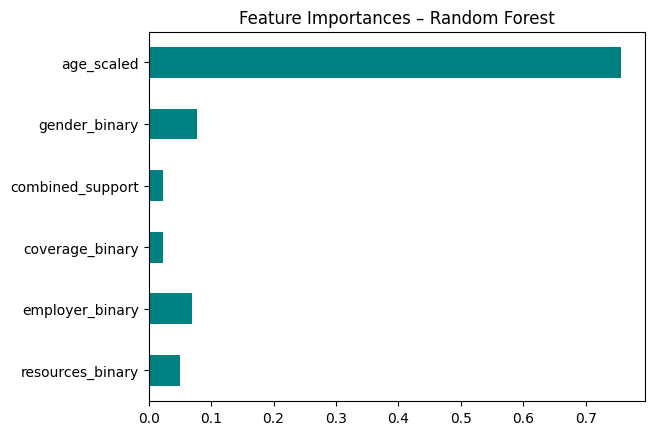

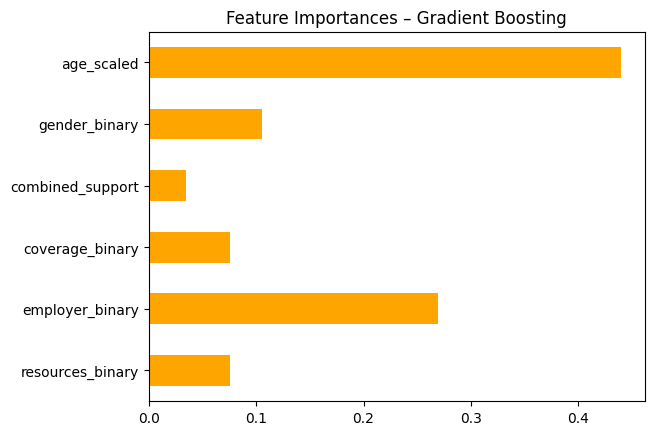

In [23]:
# Feature Importance


# Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind="barh", color="teal")
plt.title("Feature Importances – Random Forest")
plt.show()

# Gradient Boosting
gb_importances = pd.Series(gb.feature_importances_, index=X_train.columns)
gb_importances.plot(kind="barh", color="orange")
plt.title("Feature Importances – Gradient Boosting")
plt.show()

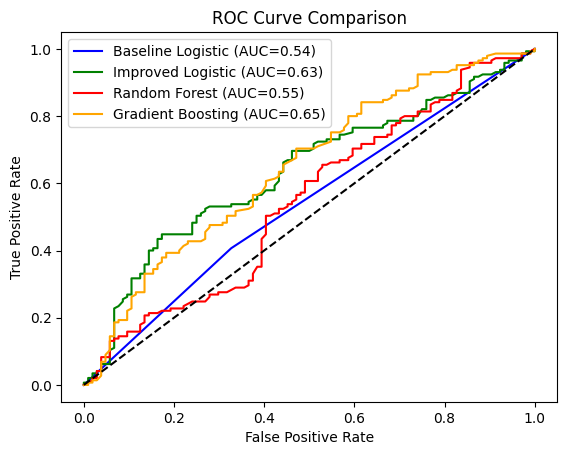

In [25]:
# ROC Comparison

fpr1,tpr1,_ = roc_curve(y_test,y_prob1)
fpr2,tpr2,_ = roc_curve(y_test,y_prob2)
fpr_rf,tpr_rf,_ = roc_curve(y_test,y_prob_rf)
fpr_gb,tpr_gb,_ = roc_curve(y_test,y_prob_gb)

plt.plot(fpr1,tpr1,label=f"Baseline Logistic (AUC={roc_auc_score(y_test,y_prob1):.2f})",color="blue")
plt.plot(fpr2,tpr2,label=f"Improved Logistic (AUC={roc_auc_score(y_test,y_prob2):.2f})",color="green")
plt.plot(fpr_rf,tpr_rf,label=f"Random Forest (AUC={roc_auc_score(y_test,y_prob_rf):.2f})",color="red")
plt.plot(fpr_gb,tpr_gb,label=f"Gradient Boosting (AUC={roc_auc_score(y_test,y_prob_gb):.2f})",color="orange")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

ROC curves confirm that both the improved logistic regression and gradient boosting outperform the baseline. Gradient boosting has the highest AUC (~0.65), indicating the strongest discriminative ability among the tested models, though performance is still moderate overall.


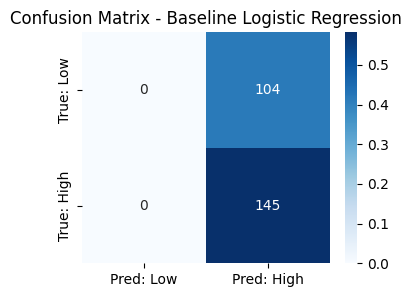

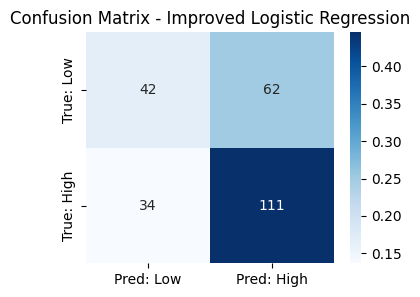

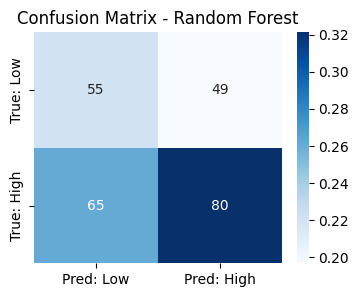

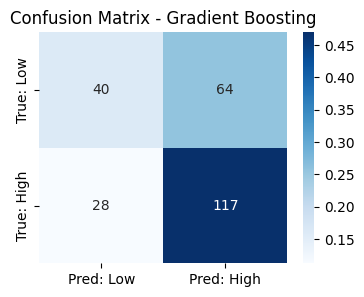

In [26]:
# Confusion Matrices

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum()
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues",
                xticklabels=["Pred: Low","Pred: High"],
                yticklabels=["True: Low","True: High"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot for each model
plot_confusion_matrix(y_test, y_pred1, "Baseline Logistic Regression")
plot_confusion_matrix(y_test, y_pred2, "Improved Logistic Regression")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_gb, "Gradient Boosting")

- Baseline logistic regression misclassified many negatives.  
- Improved logistic regression balanced false positives and negatives better.  
- Random Forest was stricter, reducing false positives at the cost of missed positives.  
- Gradient Boosting struck the best balance, with fewer errors overall.


In [27]:
# Model Performance Summary

# Collect results
baseline_results = [
    accuracy_score(y_test,y_pred1),
    precision_score(y_test,y_pred1),
    recall_score(y_test,y_pred1),
    f1_score(y_test,y_pred1),
    roc_auc_score(y_test,y_prob1)
]

improved_results = [
    accuracy_score(y_test,y_pred2),
    precision_score(y_test,y_pred2),
    recall_score(y_test,y_pred2),
    f1_score(y_test,y_pred2),
    roc_auc_score(y_test,y_prob2)
]

rf_results = [
    accuracy_score(y_test,y_pred_rf),
    precision_score(y_test,y_pred_rf),
    recall_score(y_test,y_pred_rf),
    f1_score(y_test,y_pred_rf),
    roc_auc_score(y_test,y_prob_rf)
]

gb_results = [
    accuracy_score(y_test,y_pred_gb),
    precision_score(y_test,y_pred_gb),
    recall_score(y_test,y_pred_gb),
    f1_score(y_test,y_pred_gb),
    roc_auc_score(y_test,y_prob_gb)
]

# Combine results into summary table
results = {
    "Model":["Baseline Logistic","Improved Logistic","Random Forest","Gradient Boosting"],
    "Accuracy":[baseline_results[0], improved_results[0], rf_results[0], gb_results[0]],
    "Precision":[baseline_results[1], improved_results[1], rf_results[1], gb_results[1]],
    "Recall":[baseline_results[2], improved_results[2], rf_results[2], gb_results[2]],
    "F1 Score":[baseline_results[3], improved_results[3], rf_results[3], gb_results[3]],
    "AUC":[baseline_results[4], improved_results[4], rf_results[4], gb_results[4]]
}

results_df = pd.DataFrame(results)
print("\nPerformance Summary:")
print(results_df)


Performance Summary:
               Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Baseline Logistic  0.582329   0.582329  1.000000  0.736041  0.539854
1  Improved Logistic  0.614458   0.641618  0.765517  0.698113  0.634881
2      Random Forest  0.542169   0.620155  0.551724  0.583942  0.547414
3  Gradient Boosting  0.630522   0.646409  0.806897  0.717791  0.646950


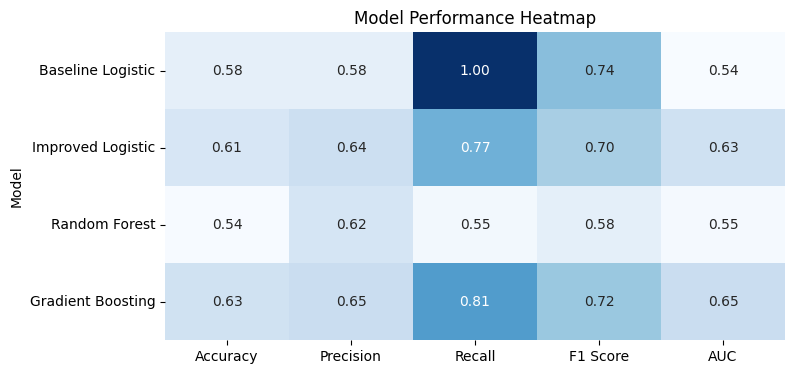

In [28]:
plt.figure(figsize=(8,4))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Model Performance Heatmap")
plt.show()

Comparing across models, Gradient Boosting emerges as the top performer, followed by Improved Logistic Regression. Random Forest underperformed in recall, while the baseline logistic model showed poor discrimination. Overall, supports clearly matter, but predictive power remains modest (AUC ~0.63–0.65).

In [29]:
# Cross-Validation

cv_scores = cross_val_score(LogisticRegression(max_iter=1000), X2, y, cv=5, scoring="roc_auc")
print(f"\nCross-validated AUC for Improved Logistic Regression: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

cv_scores_gb = cross_val_score(GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42),
                               X2, y, cv=5, scoring="roc_auc")
print(f"Cross-validated AUC for Gradient Boosting: {cv_scores_gb.mean():.3f} ± {cv_scores_gb.std():.3f}")


Cross-validated AUC for Improved Logistic Regression: 0.609 ± 0.025
Cross-validated AUC for Gradient Boosting: 0.595 ± 0.044


Cross-validation confirmed stability: Improved Logistic Regression averaged AUC ~0.61, and Gradient Boosting ~0.60. While not highly predictive, both models consistently beat chance, reinforcing the conclusion that workplace supports contribute to higher comfort.

# Conclusion

This project investigated the role of workplace supports in shaping employees’ comfort discussing mental health.  

- **Statistical Evidence:** A t-test showed employees with workplace resources scored significantly higher in comfort (mean difference = 0.44, p < 0.01).  
- **Predictive Modeling:** Baseline logistic regression was weak, but adding employer discussion, medical coverage, combined supports, and demographics improved results. Gradient Boosting performed best (AUC ~0.65, recall ~0.81), showing modest predictive power.  
- **Key Insights:** Employer-led discussions and medical coverage emerged as especially important predictors. Even modest supports, when combined, consistently increased comfort levels.  
- **Limitations:** Predictive strength remains modest, indicating that unmeasured factors (e.g., workplace culture, stigma, personal experiences) also influence mental health comfort.  

**Final Takeaway:** Workplace supports significantly improve employees’ comfort in discussing mental health, particularly when multiple supports are present. Employers can strengthen openness and well-being by offering accessible resources, fostering discussions, and ensuring medical coverage.